##  CS6910: Fundamentals of Deep Learning
#### Assignment 3 - Team 3

S Renganathan, CH16B058	     
S Nithya, CH16B113		         
Vasistha Singhal, CH16B119

### Run this cell only once (the first ever time you run) to process data

In [ ]:
# # from google.colab import drive
# # drive.mount('/content/drive')

# # For extracting
# !pip install pyunpack
# !pip install patool

# from pyunpack import Archive
# Archive('CUB_200_2011.tgz').extractall('Assignment3_Data')

In [18]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
import pandas as pd
import os
import re
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from io import StringIO
from PIL import Image
import re
from sklearn.metrics import accuracy_score, f1_score, precision_score
import pickle
import torchvision.models as models

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
class DatasetClass(Dataset):
    
    def __init__(self, directory, img_size):
        
        self.directory = directory
        self.classes = ['026.Bronzed_Cowbird',	'084.Red_legged_Kittiwake',	'131.Vesper_Sparrow',	'085.Horned_Lark',	'015.Lazuli_Bunting',	'041.Scissor_tailed_Flycatcher',	'114.Black_throated_Sparrow']
        print('Number of Classes =', len(self.classes))
        self.files = []
        for class_name in self.classes:
            images = os.listdir(directory + '/' + class_name)
            images = [class_name + '/' + image for image in images]
            self.files.extend(images)
        
        self.img_size = img_size
        self.size = len(self.files)
        
    def __getitem__(self, idx):     
        
        image_name = self.files[idx]
        y = self.classes.index(re.split('/', image_name)[0])
        img = Image.open(self.directory + '/' + image_name).convert(mode='RGB').resize(self.img_size)
        
        trans = transforms.ToTensor()
        # return trans(img), torch.Tensor(y, dtype=torch.long)
        
        return trans(img), y        # Multiplying by pixel value
      
    def __len__(self):
        
        return self.size

In [5]:
def train_test_loader(directory, img_size, train_fraction=0.7, cv_fraction=0.2, num_workers=0, batch_size=32):

    dataset = DatasetClass(directory, img_size)
    
    N = dataset.size
    train_size = int(N*train_fraction)
    cv_size = int(N*cv_fraction)
    test_size = N - train_size - cv_size

    train_data, cv_data, test_data = torch.utils.data.random_split(dataset, [train_size, cv_size, test_size])

    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    cvloader = DataLoader(cv_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return trainloader, cvloader, testloader, train_size, cv_size, test_size

In [6]:
# trainloader, cvloader, testloader, train_size, cv_size, test_size = train_test_loader('D:/_SEM8/DL/Assignment 3/Assignment3_Data/CUB_200_2011/images/', (224, 224))
trainloader, cvloader, testloader, train_size, cv_size, test_size = train_test_loader('/content/drive/My Drive/Assignment3_Data/CUB_200_2011/images', (224, 224), batch_size=32)

# if __name__ == "__main__":
  # trainloader, cvloader, testloader, train_size, cv_size, test_size = train_test_loader('Assignment3_Data/CUB_200_2011/images/', (224, 224))

Number of Classes = 7


In [ ]:
RGB_mean = torch.zeros(3)
i = 0
for X, y in trainloader:
    i += 1
    RGB_mean += (X.sum(0).sum(1).sum(1)/(X.shape[2]*X.shape[2]))/train_size
    print(i, '/', len(trainloader), end=', ')

1 / 9, 2 / 9, 3 / 9, 4 / 9, 5 / 9, 6 / 9, 7 / 9, 8 / 9, 9 / 9, 

### Question 1. a


In [ ]:
class VGGNet(nn.Module):
    
    def __init__(self, RGB_mean, num_classes):
        super(VGGNet, self).__init__()
        
        self.RGB_mean = RGB_mean.to(device)
        self.num_classes = num_classes

        self.c11 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.c12 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.p1 = nn.MaxPool2d(2, stride=2)

        self.c21 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.c22 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.p2 = nn.MaxPool2d(2, stride=2)

        self.c31 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.c32 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.c33 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.p3 = nn.MaxPool2d(2, stride=2)

        self.c41 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.c42 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.c43 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.p4 = nn.MaxPool2d(2, stride=2)

        self.c51 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.c52 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.c53 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.p5 = nn.MaxPool2d(2, stride=2)

        self.flat = nn.Flatten(1, -1)
        self.fc1 = nn.Linear(7*7*512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.out = nn.Linear(4096, self.num_classes)

    def forward(self, x):

        x = x - self.RGB_mean[None, :, None, None]
        x = self.p1(F.relu(self.c12(F.relu(self.c11(x)))))
        x = self.p1(F.relu(self.c22(F.relu(self.c21(x)))))
        x = self.p3(F.relu(self.c33(F.relu(self.c32(F.relu(self.c31(x)))))))
        x = self.p4(F.relu(self.c43(F.relu(self.c42(F.relu(self.c41(x)))))))
        x = self.p5(F.relu(self.c53(F.relu(self.c52(F.relu(self.c51(x)))))))
        x = F.relu(self.fc2(F.relu(self.fc1(self.flat(x)))))
        Z = self.out(x)


        return Z

In [ ]:
VGG_model = VGGNet(RGB_mean, 7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# vgg16 = models.vgg16(pretrained=True)
# pickle.dump(vgg16, open('/content/drive/My Drive/vgg_init.sav', 'wb'))

In [ ]:
vgg16 = pickle.load(open('/content/drive/My Drive/vgg_init.sav', 'rb'))

In [ ]:
params = list(vgg16.parameters())

with torch.no_grad():
    
    VGG_model.c11.weight = params[0]
    VGG_model.c11.bias = params[1]
    VGG_model.c12.weight = params[2]
    VGG_model.c12.bias = params[3]
    
    VGG_model.c21.weight = params[4]
    VGG_model.c21.bias = params[5]
    VGG_model.c22.weight = params[6]
    VGG_model.c22.bias = params[7]

    VGG_model.c31.weight = params[8]
    VGG_model.c31.bias = params[9]
    VGG_model.c32.weight = params[10]
    VGG_model.c32.bias = params[11]
    VGG_model.c33.weight = params[12]
    VGG_model.c33.bias = params[13]

    VGG_model.c41.weight = params[14]
    VGG_model.c41.bias = params[15]
    VGG_model.c42.weight = params[16]
    VGG_model.c42.bias = params[17]
    VGG_model.c43.weight = params[18]
    VGG_model.c43.bias = params[19]

    VGG_model.c51.weight = params[20]
    VGG_model.c51.bias = params[21]
    VGG_model.c52.weight = params[22]
    VGG_model.c52.bias = params[23]
    VGG_model.c53.weight = params[24]
    VGG_model.c53.bias = params[25]

    VGG_model.fc1.weight = params[26]
    VGG_model.fc1.bias = params[27]

    VGG_model.fc2.weight = params[28]
    VGG_model.fc2.bias = params[29]

VGG_model = VGG_model.to(device)

Epoch 1 : Loss = 1.8460866445448338 inf
Epoch 2 : Loss = 1.0807606449110583 0.70813644375139
Epoch 3 : Loss = 0.6524373722824071 0.6564971456651195
Epoch 4 : Loss = 0.4732703884304193 0.3785721402223944
Epoch 5 : Loss = 0.38688288800392423 0.22329108654094523
Epoch 6 : Loss = 0.32553923711544136 0.18843704197392783
Epoch 7 : Loss = 0.2902372030846333 0.12163166422367284
Epoch 8 : Loss = 0.26113165608681865 0.11145928239408057
Epoch 9 : Loss = 0.24088090819141178 0.08406954310930682
Epoch 10 : Loss = 0.2186906454558987 0.10146873310128844
Epoch 11 : Loss = 0.20416518692770902 0.0711456186373873
Epoch 12 : Loss = 0.19065284765348203 0.07087404904009678
Epoch 13 : Loss = 0.17924669883392416 0.06363380131271432
Epoch 14 : Loss = 0.16815741092797357 0.06594587681122446
Epoch 15 : Loss = 0.15963291021174253 0.05340064717810287
Epoch 16 : Loss = 0.150935411323446 0.057623978442396605
Epoch 17 : Loss = 0.14390422232475014 0.04886019940977488
Epoch 18 : Loss = 0.13576473467026023 0.059952885955

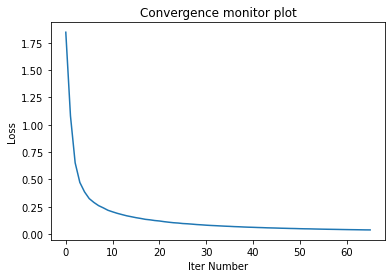

In [ ]:
old_loss = np.inf

max_epoch = 100
losses = []
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, y = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = VGG_model(X)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss, abs(running_loss-old_loss)/running_loss)
    losses.append(running_loss)

    if abs(running_loss-old_loss)/running_loss < 1e-2 and running_loss<0.05:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [ ]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = VGG_model(X)
        train_loss += criterion(y_hat, y)*len(X)/train_size
        
        y_train.extend(list(y.detach().cpu().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Train Loss =', train_loss.item())
pd.DataFrame(confusion_matrix(y_train, y_train_pred))

Train Loss = 0.03823063522577286


,0,1,2,3,4,5,6
0,43,0,0,0,0,0,0
1,0,36,0,0,0,0,0
2,0,0,46,0,0,0,0
3,0,0,0,37,0,0,0
4,0,0,0,0,40,0,0
5,0,0,0,0,0,42,0
6,0,0,0,0,0,0,43


In [ ]:
acc_tr = accuracy_score(y_train, y_train_pred)
prec_tr = precision_score(y_train, y_train_pred, average='weighted')
f1_tr = f1_score(y_train, y_train_pred, average='weighted')

print('Train Accuracy =', acc_tr, 'Train Precision =', prec_tr, 'Train F1 =', f1_tr)

Train Accuracy = 1.0 Train Precision = 1.0 Train F1 = 1.0


In [ ]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = VGG_model(X)      
        test_loss += criterion(y_hat, y)*len(X)/test_size
        
        y_test.extend(list(y.detach().cpu().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Test Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Test Loss = 0.27743086218833923


,0,1,2,3,4,5,6
0,8,0,0,0,0,0,0
1,0,8,0,0,0,0,0
2,0,0,2,1,0,0,0
3,0,0,1,8,0,0,1
4,0,0,0,1,4,0,0
5,0,0,0,0,0,4,0
6,0,0,0,0,0,0,4


In [ ]:
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)

Test Accuracy = 0.9047619047619048 Test Precision = 0.8952380952380953 Test F1 = 0.8920634920634922


In [ ]:
torch.save(VGG_model, '/content/drive/My Drive/A3Q1a_model.pt')

### Question 1. b

In [ ]:
class GoogLeNet(nn.Module):
    
    def __init__(self, n_classes, RGB_mean):
    
        super(GoogLeNet, self).__init__()
        self.RGB_mean = RGB_mean.to(device)
        self.n_classes = n_classes
        # Convolution
        # 3x224x224
        self.c1 = nn.Conv2d(3, 64, 7, stride=2, padding=3)
        # 64x112x112
        self.mp1 = nn.MaxPool2d(3, stride=2, padding=1)

        # Deep Convolution
        # 64x56x56
        self.c21 = nn.Conv2d(64, 64, 1, stride=1, padding=0)
        # 64x56x56
        self.c22 = nn.Conv2d(64, 192, 3, stride=1, padding=1)
        # 192x56x56
        self.mp2 = nn.MaxPool2d(3, stride=2)

        # Inception 3a
        # 192x28x28
        # P1
        self.c3a1 = nn.Conv2d(192, 64, 1, stride=1, padding=0)
        # P2
        self.c3a21 = nn.Conv2d(192, 96, 1, stride=1, padding=0)
        self.c3a22 = nn.Conv2d(96, 128, 3, stride=1, padding=1)
        # P3
        self.c3a31 = nn.Conv2d(192, 16, 1, stride=1, padding=0)
        self.c3a32 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        # P4
        self.mp3a4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c3a4 = nn.Conv2d(192, 32, 1, stride=1, padding=0)

        # Inception 3b
        # 256x28x28
        # P1
        self.c3b1 = nn.Conv2d(256, 128, 1, stride=1, padding=0)
        # P2
        self.c3b21 = nn.Conv2d(256, 128, 1, stride=1, padding=0)
        self.c3b22 = nn.Conv2d(128, 192, 3, stride=1, padding=1)
        # P3
        self.c3b31 = nn.Conv2d(256, 32, 1, stride=1, padding=0)
        self.c3b32 = nn.Conv2d(32, 96, 3, stride=1, padding=1)
        # P4
        self.mp3b4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c3b4 = nn.Conv2d(256, 64, 1, stride=1, padding=0)

        # 480x28x28
        # MP
        self.mp3 = nn.MaxPool2d(3, stride=2, padding=1)

        # Inception 4a
        # 480x14x14
        # P1
        self.c4a1 = nn.Conv2d(480, 192, 1, stride=1, padding=0)
        # P2
        self.c4a21 = nn.Conv2d(480, 96, 1, stride=1, padding=0)
        self.c4a22 = nn.Conv2d(96, 208, 3, stride=1, padding=1)
        # P3
        self.c4a31 = nn.Conv2d(480, 16, 1, stride=1, padding=0)
        self.c4a32 = nn.Conv2d(16, 48, 3, stride=1, padding=1)
        # P4
        self.mp4a4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c4a4 = nn.Conv2d(480, 64, 1, stride=1, padding=0)

        # Auxiliary 1
        # 512x14x14
        self.apa1 = nn.AvgPool2d(5, stride=3, padding=0)
        # 512x4x4
        self.ca1 = nn.Conv2d(512, 128, 1, stride=1)
        # 128x4x4
        self.flat1 = nn.Flatten(1, -1)
        # (128x4x4)x1
        self.fca1 = nn.Linear(2048, 1024)
        self.a1drop = nn.Dropout(0.7)
        self.a1out = nn.Linear(1024, self.n_classes)

        # Inception 4b
        # 512x14x14
        # P1
        self.c4b1 = nn.Conv2d(512, 160, 1, stride=1, padding=0)
        # P2
        self.c4b21 = nn.Conv2d(512, 112, 1, stride=1, padding=0)
        self.c4b22 = nn.Conv2d(112, 224, 3, stride=1, padding=1)
        # P3
        self.c4b31 = nn.Conv2d(512, 24, 1, stride=1, padding=0)
        self.c4b32 = nn.Conv2d(24, 64, 3, stride=1, padding=1)
        # P4
        self.mp4b4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c4b4 = nn.Conv2d(512, 64, 1, stride=1, padding=0)

        # Inception 4c
        # 512x14x14
        # P1
        self.c4c1 = nn.Conv2d(512, 128, 1, stride=1, padding=0)
        # P2
        self.c4c21 = nn.Conv2d(512, 128, 1, stride=1, padding=0)
        self.c4c22 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        # P3
        self.c4c31 = nn.Conv2d(512, 24, 1, stride=1, padding=0)
        self.c4c32 = nn.Conv2d(24, 64, 3, stride=1, padding=1)
        # P4
        self.mp4c4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c4c4 = nn.Conv2d(512, 64, 1, stride=1, padding=0)

        # Inception 4d
        # 512x14x14
        # P1
        self.c4d1 = nn.Conv2d(512, 112, 1, stride=1, padding=0)
        # P2
        self.c4d21 = nn.Conv2d(512, 144, 1, stride=1, padding=0)
        self.c4d22 = nn.Conv2d(144, 288, 3, stride=1, padding=1)
        # P3
        self.c4d31 = nn.Conv2d(512, 32, 1, stride=1, padding=0)
        self.c4d32 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        # P4
        self.mp4d4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c4d4 = nn.Conv2d(512, 64, 1, stride=1, padding=0)

        # Auxiliary 2
        # 528x14x14
        self.apa2 = nn.AvgPool2d(5, stride=3, padding=0)
        # 528x4x4
        self.ca2 = nn.Conv2d(528, 128, 1, stride=1)
        # 128x4x4
        self.flat1 = nn.Flatten(1, -1)
        # (128x4x4)x1
        self.fca2 = nn.Linear(2048, 1024)
        self.a2drop = nn.Dropout(0.7)
        self.a2out = nn.Linear(1024, self.n_classes)

        # Inception 4e
        # 528x14x14
        # P1
        self.c4e1 = nn.Conv2d(528, 256, 1, stride=1, padding=0)
        # P2
        self.c4e21 = nn.Conv2d(528, 160, 1, stride=1, padding=0)
        self.c4e22 = nn.Conv2d(160, 320, 3, stride=1, padding=1)
        # P3
        self.c4e31 = nn.Conv2d(528, 32, 1, stride=1, padding=0)
        self.c4e32 = nn.Conv2d(32, 128, 3, stride=1, padding=1)
        # P4
        self.mp4e4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c4e4 = nn.Conv2d(528, 128, 1, stride=1, padding=0)

        # 832x14x14
        # MP
        self.mp4 = nn.MaxPool2d(3, stride=2, padding=1)

        # Inception 5a
        # 832x7x7
        # P1
        self.c5a1 = nn.Conv2d(832, 256, 1, stride=1, padding=0)
        # P2
        self.c5a21 = nn.Conv2d(832, 160, 1, stride=1, padding=0)
        self.c5a22 = nn.Conv2d(160, 320, 3, stride=1, padding=1)
        # P3
        self.c5a31 = nn.Conv2d(832, 32, 1, stride=1, padding=0)
        self.c5a32 = nn.Conv2d(32, 128, 3, stride=1, padding=1)
        # P4
        self.mp5a4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c5a4 = nn.Conv2d(832, 128, 1, stride=1, padding=0)

        # Inception 5b
        # 832x7x7
        # P1
        self.c5b1 = nn.Conv2d(832, 384, 1, stride=1, padding=0)
        # P2
        self.c5b21 = nn.Conv2d(832, 192, 1, stride=1, padding=0)
        self.c5b22 = nn.Conv2d(192, 384, 3, stride=1, padding=1)
        # P3
        self.c5b31 = nn.Conv2d(832, 48, 1, stride=1, padding=0)
        self.c5b32 = nn.Conv2d(48, 128, 3, stride=1, padding=1)
        # P4
        self.mp5b4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c5b4 = nn.Conv2d(832, 128, 1, stride=1, padding=0)

        # 1024x7x7
        self.ap = nn.AvgPool2d(7, stride=1)
        # 1024x1x1
        self.drop = nn.Dropout(0.4)
        self.flat = nn.Flatten(1, -1)
        self.out = nn.Linear(1024, self.n_classes)

    def forward(self, x, auxiliary=True):

        x = x - self.RGB_mean[None, :, None, None]

        # Layer 1
        x = self.mp1(F.relu(self.c1(x)))

        # Layer 2
        x = self.mp2(F.relu(self.c22(F.relu(self.c21(x)))))

        # Layer 3a
        x1 = F.relu(self.c3a1(x))
        x2 = F.relu(self.c3a22(F.relu(self.c3a21(x))))
        x3 = F.relu(self.c3a32(F.relu(self.c3a31(x))))
        x4 = F.relu(self.c3a4(self.mp3a4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Layer 3b
        x1 = F.relu(self.c3b1(x))
        x2 = F.relu(self.c3b22(F.relu(self.c3b21(x))))
        x3 = F.relu(self.c3b32(F.relu(self.c3b31(x))))
        x4 = F.relu(self.c3b4(self.mp3b4(x)))
        x = self.mp3(torch.cat((x1, x2, x3, x4), 1))

        # Layer 4a
        x1 = F.relu(self.c4a1(x))
        x2 = F.relu(self.c4a22(F.relu(self.c4a21(x))))
        x3 = F.relu(self.c4a32(F.relu(self.c4a31(x))))
        x4 = F.relu(self.c4a4(self.mp4a4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Auxiliary 1
        if auxiliary == True:
            z1 = self.flat1(F.relu(self.ca1(self.apa1(x))))
            z1 = self.a1out(self.a1drop(F.relu(self.fca1(z1))))
        else:
            z1 = None

        # Layer 4b
        x1 = F.relu(self.c4b1(x))
        x2 = F.relu(self.c4b22(F.relu(self.c4b21(x))))
        x3 = F.relu(self.c4b32(F.relu(self.c4b31(x))))
        x4 = F.relu(self.c4b4(self.mp4b4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Layer 4c
        x1 = F.relu(self.c4c1(x))
        x2 = F.relu(self.c4c22(F.relu(self.c4c21(x))))
        x3 = F.relu(self.c4c32(F.relu(self.c4c31(x))))
        x4 = F.relu(self.c4c4(self.mp4c4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Layer 4d
        x1 = F.relu(self.c4d1(x))
        x2 = F.relu(self.c4d22(F.relu(self.c4d21(x))))
        x3 = F.relu(self.c4d32(F.relu(self.c4d31(x))))
        x4 = F.relu(self.c4d4(self.mp4d4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Auxiliary 2
        if auxiliary == True:
            z2 = self.flat(F.relu(self.ca2(self.apa2(x))))
            z2 = self.a2out(self.a2drop(F.relu(self.fca2(z2))))
        else:
            z2 = None

        # Layer 4e
        x1 = F.relu(self.c4e1(x))
        x2 = F.relu(self.c4e22(F.relu(self.c4e21(x))))
        x3 = F.relu(self.c4e32(F.relu(self.c4e31(x))))
        x4 = F.relu(self.c4e4(self.mp4e4(x)))
        x = self.mp4(torch.cat((x1, x2, x3, x4), 1))

        # Layer 5a
        x1 = F.relu(self.c5a1(x))
        x2 = F.relu(self.c5a22(F.relu(self.c5a21(x))))
        x3 = F.relu(self.c5a32(F.relu(self.c5a31(x))))
        x4 = F.relu(self.c5a4(self.mp5a4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Layer 5b
        x1 = F.relu(self.c5b1(x))
        x2 = F.relu(self.c5b22(F.relu(self.c5b21(x))))
        x3 = F.relu(self.c5b32(F.relu(self.c5b31(x))))
        x4 = F.relu(self.c5b4(self.mp5b4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Final Output
        x = self.out(self.flat(self.drop(self.ap(x))))

        return x, z1, z2

    
    def predict(self, x):

        y_hat = self.forward(x)
        y_hat = torch.argmax(y_hat, axis=1)
        return y_hat

In [ ]:
# googlenet = models.googlenet(pretrained=True)
# pickle.dump(googlenet, open('/content/drive/My Drive/google_init.sav', 'wb'))

In [ ]:
googlenet = pickle.load(open('/content/drive/My Drive/google_init.sav', 'rb'))

In [ ]:
classifier = GoogLeNet(7, RGB_mean)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

In [ ]:
params = list(googlenet.parameters())

with torch.no_grad():
    
    classifier.c1.weight = params[0]
    # classifier.c1.bias = params[1]

    classifier.c21.weight = params[3]
    # classifier.c21.bias = params[4]
    classifier.c22.weight = params[6]
    # classifier.c22.bias = params[7]

    classifier.c3a1.weight = params[9]
    # classifier.c3a1.bias = params[10]
    classifier.c3a21.weight = params[12]
    # classifier.c3a21.bias = params[13]
    classifier.c3a22.weight = params[15]
    # classifier.c3a22.bias = params[16]
    classifier.c3a31.weight = params[18]
    # classifier.c3a31.bias = params[19]
    classifier.c3a32.weight = params[21]
    # classifier.c3a32.bias = params[22]
    classifier.c3a4.weight = params[24]
    # classifier.c3a4.bias = params[25]
    
    classifier.c3b1.weight = params[27]
    # classifier.c3b1.bias = params[28]
    classifier.c3b21.weight = params[30]
    # classifier.c3b21.bias = params[31]
    classifier.c3b22.weight = params[33]
    # classifier.c3b22.bias = params[34]
    classifier.c3b31.weight = params[36]
    # classifier.c3b31.bias = params[37]
    classifier.c3b32.weight = params[39]
    # classifier.c3b32.bias = params[40]
    classifier.c3b4.weight = params[42]
    # classifier.c3b4.bias = params[43]
    
    classifier.c4a1.weight = params[45]
    # classifier.c4a1.bias = params[46]
    classifier.c4a21.weight = params[48]
    # classifier.c4a21.bias = params[49]
    classifier.c4a22.weight = params[51]
    # classifier.c4a22.bias = params[52]
    classifier.c4a31.weight = params[54]
    # classifier.c4a31.bias = params[55]
    classifier.c4a32.weight = params[57]
    # classifier.c4a32.bias = params[58]
    classifier.c4a4.weight = params[60]
    # classifier.c4a4.bias = params[61]

    classifier.c4b1.weight = params[63]
    # classifier.c4b1.bias = params[64]
    classifier.c4b21.weight = params[66]
    # classifier.c4b21.bias = params[67]
    classifier.c4b22.weight = params[69]
    # classifier.c4b22.bias = params[70]
    classifier.c4b31.weight = params[72]
    # classifier.c4b31.bias = params[73]
    classifier.c4b32.weight = params[75]
    # classifier.c4b32.bias = params[76]
    classifier.c4b4.weight = params[78]
    # classifier.c4b4.bias = params[79]

    classifier.c4c1.weight = params[81]
    # classifier.c4c1.bias = params[82]
    classifier.c4c21.weight = params[84]
    # classifier.c4c21.bias = params[85]
    classifier.c4c22.weight = params[87]
    # classifier.c4c22.bias = params[88]
    classifier.c4c31.weight = params[90]
    # classifier.c4c31.bias = params[91]
    classifier.c4c32.weight = params[93]
    # classifier.c4c32.bias = params[94]
    classifier.c4c4.weight = params[96]
    # classifier.c4c4.bias = params[97]

    classifier.c4d1.weight = params[99]
    # classifier.c4d1.bias = params[100]
    classifier.c4d21.weight = params[102]
    # classifier.c4d21.bias = params[103]
    classifier.c4d22.weight = params[105]
    # classifier.c4d22.bias = params[106]
    classifier.c4d31.weight = params[108]
    # classifier.c4d31.bias = params[109]
    classifier.c4d32.weight = params[111]
    # classifier.c4d32.bias = params[112]
    classifier.c4d4.weight = params[114]
    # classifier.c4d4.bias = params[115]

    classifier.c4e1.weight = params[117]
    # classifier.c4e1.bias = params[118]
    classifier.c4e21.weight = params[120]
    # classifier.c4e21.bias = params[121]
    classifier.c4e22.weight = params[123]
    # classifier.c4e22.bias = params[124]
    classifier.c4e31.weight = params[126]
    # classifier.c4e31.bias = params[127]
    classifier.c4e32.weight = params[129]
    # classifier.c4e32.bias = params[130]
    classifier.c4e4.weight = params[132]
    # classifier.c4e4.bias = params[133]

    classifier.c5a1.weight = params[135]
    # classifier.c5a1.bias = params[136]
    classifier.c5a21.weight = params[138]
    # classifier.c5a21.bias = params[139]
    classifier.c5a22.weight = params[141]
    # classifier.c5a22.bias = params[142]
    classifier.c5a31.weight = params[144]
    # classifier.c5a31.bias = params[145]
    classifier.c5a32.weight = params[147]
    # classifier.c5a32.bias = params[148]
    classifier.c5a4.weight = params[150]
    # classifier.c5a4.bias = params[151]

    classifier.c5b1.weight = params[153]
    # classifier.c5b1.bias = params[154]
    classifier.c5b21.weight = params[156]
    # classifier.c5b21.bias = params[157]
    classifier.c5b22.weight = params[159]
    # classifier.c5b22.bias = params[160]
    classifier.c5b31.weight = params[162]
    # classifier.c5b31.bias = params[163]
    classifier.c5b32.weight = params[165]
    # classifier.c5b32.bias = params[166]
    classifier.c5b4.weight = params[168]
    # classifier.c5b4.bias = params[169]

classifier = classifier.to(device)

Epoch 1 : Loss = 3.1121552248034323
Epoch 2 : Loss = 3.1037406331570723
Epoch 3 : Loss = 3.100610318499575
Epoch 4 : Loss = 3.098109191303054
Epoch 5 : Loss = 3.083987043294342
Epoch 6 : Loss = 3.075826416447603
Epoch 7 : Loss = 3.066208663302432
Epoch 8 : Loss = 3.0496589456285745
Epoch 9 : Loss = 3.026289643310919
Epoch 10 : Loss = 3.018028483573568
Epoch 11 : Loss = 2.9945229412371273
Epoch 12 : Loss = 2.990751808113337
Epoch 13 : Loss = 2.969864595227125
Epoch 14 : Loss = 2.9476608922672605
Epoch 15 : Loss = 2.9458387761996603
Epoch 16 : Loss = 2.932173090113995
Epoch 17 : Loss = 2.9030247108446185
Epoch 18 : Loss = 2.876336592830432
Epoch 19 : Loss = 2.8782254935141642
Epoch 20 : Loss = 2.8447000814231846
Epoch 21 : Loss = 2.8092686689689184
Epoch 22 : Loss = 2.8065642562892794
Epoch 23 : Loss = 2.768598222566399
Epoch 24 : Loss = 2.7850758929701223
Epoch 25 : Loss = 2.75470313128694
Epoch 26 : Loss = 2.7355639012433093
Epoch 27 : Loss = 2.712163524760602
Epoch 28 : Loss = 2.67563

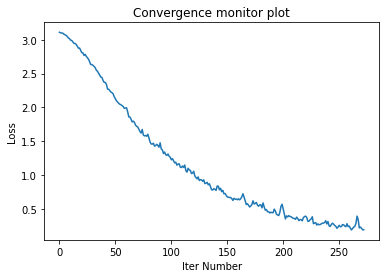

In [ ]:
old_loss = np.inf

max_epoch = 500
losses = []
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, y = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat, y_hat1, y_hat2 = classifier(X)
        
        # Calculate Loss (Cross Entropy)
        loss_main = criterion(y_hat, y)
        loss1 = criterion(y_hat1, y)
        loss2 = criterion(y_hat2, y)

        # Weighted Loss
        loss = loss_main + 0.3*loss1 + 0.3*loss2

        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)
    if abs(running_loss-old_loss)/running_loss < 0.05 and running_loss<0.2:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [ ]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat, _, _ = classifier(X)      
        train_loss += criterion(y_hat, y)*len(X)/train_size
        
        y_train.extend(list(y.detach().cpu().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Train Loss =', train_loss.item())
pd.DataFrame(confusion_matrix(y_train, y_train_pred))

Train Loss = 0.1609659045934677


,0,1,2,3,4,5,6
0,42,0,0,0,0,0,1
1,0,36,0,0,0,0,0
2,0,0,43,1,2,0,0
3,0,0,0,36,0,0,1
4,0,0,0,0,40,0,0
5,0,0,0,0,2,40,0
6,0,0,0,0,0,0,43


In [ ]:
acc = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')

print('Train Accuracy =', acc, 'Train Precision =', prec, 'Train F1 =', f1)

Train Accuracy = 0.975609756097561 Train Precision = 0.9768027768027768 Train F1 = 0.9761091196676174


In [ ]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat, _, _ = classifier(X)      
        test_loss += criterion(y_hat, y)*len(X)/test_size
        
        y_test.extend(list(y.detach().cpu().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Test Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Test Loss = 1.312967300415039


,0,1,2,3,4,5,6
0,4,0,0,0,1,1,2
1,0,4,0,1,0,1,2
2,1,0,2,0,0,0,0
3,0,0,1,8,0,1,0
4,0,0,0,0,4,0,1
5,0,0,0,0,1,2,1
6,0,0,1,0,0,0,3


In [ ]:
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)
torch.save(classifier, '/content/drive/My Drive/A3Q1b_model.pt')

Test Accuracy = 0.6428571428571429 Test Precision = 0.6555555555555556 Test F1 = 0.6184058214133402


### Question 2

In [ ]:
class CNN2(nn.Module):
    
    def __init__(self, n_classes):
        super(CNN2, self).__init__()

        self.n_classes = n_classes
        # 3x224x224
        self.cl1 = nn.Conv2d(3, 4, 3, stride=1, padding=1)
        # 4x224x224
        self.pl1 = nn.AvgPool2d(2, stride=2)
        # 4x112x112
        self.cl2 = nn.Conv2d(4, 16, 3, stride=1, padding=1)
        # 16x112x112
        self.pl2 = nn.AvgPool2d(2, stride=2)

        # 16x56x56
        self.flat = nn.Flatten(1, -1)
        # (16x56x56)x1
        self.out = nn.Linear(16*56*56, self.n_classes)


    def forward(self, x):
        
        x = self.pl1(F.relu(self.cl1(x)))
        x = self.pl2(F.relu(self.cl2(x)))
        x = self.out(self.flat(x))

        return x


    def predict(self, x):

        y_hat = self.forward(x)
        y_hat = torch.argmax(y_hat, axis=1)
        return y_hat

In [ ]:
classifier = CNN2(7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.00005, momentum=0.9)
classifier = classifier.to(device)

Epoch 1 : Loss = 1.9484334253683324
Epoch 2 : Loss = 1.947373752809983
Epoch 3 : Loss = 1.9462925332763885
Epoch 4 : Loss = 1.9449584060429694
Epoch 5 : Loss = 1.9439449260459127
Epoch 6 : Loss = 1.9427635395568421
Epoch 7 : Loss = 1.9418055026788745
Epoch 8 : Loss = 1.940997310631782
Epoch 9 : Loss = 1.9404067469806208
Epoch 10 : Loss = 1.9397513779198252
Epoch 11 : Loss = 1.9390972383346292
Epoch 12 : Loss = 1.938540056607449
Epoch 13 : Loss = 1.9379960842664232
Epoch 14 : Loss = 1.9372729299791183
Epoch 15 : Loss = 1.9368470446157953
Epoch 16 : Loss = 1.9365565810054022
Epoch 17 : Loss = 1.9359457754507299
Epoch 18 : Loss = 1.935442887532171
Epoch 19 : Loss = 1.9347893161640763
Epoch 20 : Loss = 1.93448837168956
Epoch 21 : Loss = 1.9339445463871707
Epoch 22 : Loss = 1.9335623850805834
Epoch 23 : Loss = 1.9328854491071004
Epoch 24 : Loss = 1.932512533373949
Epoch 25 : Loss = 1.9318959422227813
Epoch 26 : Loss = 1.9314164147559776
Epoch 27 : Loss = 1.931144365450231
Epoch 28 : Loss = 

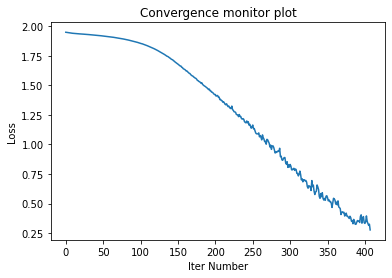

In [ ]:
old_loss = np.inf
losses = []
max_epoch = 500
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
            
        X, y = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = classifier(X)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)

        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)/train_size

    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)

    if (abs(running_loss-old_loss)/running_loss < 0.2) and running_loss<0.3:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [ ]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        train_loss += criterion(y_hat, y)*len(X)/train_size
        
        y_train.extend(list(y.detach().cpu().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Train Loss =', train_loss.item())
pd.DataFrame(confusion_matrix(y_train, y_train_pred))

Train Loss = 0.2829172909259796


,0,1,2,3,4,5,6
0,43,0,0,0,0,0,0
1,0,30,1,0,0,2,3
2,0,0,45,0,0,0,1
3,0,0,1,32,0,0,4
4,0,0,1,0,36,0,3
5,0,0,3,0,0,38,1
6,0,0,0,0,0,0,43


In [ ]:
acc_tr = accuracy_score(y_train, y_train_pred)
prec_tr = precision_score(y_train, y_train_pred, average='weighted')
f1_tr = f1_score(y_train, y_train_pred, average='weighted')

print('Train Accuracy =', acc_tr, 'Train Precision =', prec_tr, 'Train F1 =', f1_tr)

Train Accuracy = 0.9303135888501742 Train Precision = 0.941137341854702 Train F1 = 0.9312989047598114


In [ ]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        test_loss += criterion(y_hat, y)*len(X)/test_size
        
        y_test.extend(list(y.detach().cpu().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Test Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Test Loss = 3.4638450145721436


,0,1,2,3,4,5,6
0,4,0,0,0,0,2,2
1,0,0,1,0,1,5,1
2,1,0,1,0,0,0,1
3,0,0,4,1,0,0,5
4,0,1,3,0,0,1,0
5,1,0,1,0,0,2,0
6,0,0,0,0,0,1,3


In [ ]:
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)

Test Accuracy = 0.2619047619047619 Test Precision = 0.31406926406926405 Test F1 = 0.2212513676799391


In [ ]:
pickle.dump(list(classifier.parameters()), open('/content/drive/My Drive/A3Q2_params.sav', 'wb'))
torch.save(classifier, '/content/drive/My Drive/A3Q2_model.pt')

## Question 3

In [7]:
params = pickle.load(open('/content/drive/My Drive/A3Q2_params.sav', 'rb'))

In [8]:
class CNN3(nn.Module):
    
    def __init__(self, n_classes, k=4):
        super(CNN3, self).__init__()

        self.n_classes = n_classes
        # 3x224x224
        self.cl1 = nn.Conv2d(3, 4, 3, stride=1, padding=1)
        # 4x224x224
        self.pl1 = nn.AvgPool2d(2, stride=2)
        # 4x112x112
        self.cl2 = nn.Conv2d(4, 16, 3, stride=1, padding=1)
        # 16x112x112
        self.pl2 = nn.AvgPool2d(2, stride=2)

        # NetVLAD
        self.K = k
        self.nv_conv = nn.Conv2d(16, self.K, 1)
        self.nv_soft_ass = nn.Softmax2d()

        # NetVLAD Parameter
        self.c = nn.Parameter(torch.rand(self.K, 16))
        
        # Flatten to get h
        self.flat = nn.Flatten(1, -1)

        # Output layer
        self.out = nn.Linear(self.K*16, self.n_classes)
        

    def forward(self, x):
        
        # print(x.shape)
        x = self.pl1(F.relu(self.cl1(x)))
        # print(x.shape)
        x = self.pl2(F.relu(self.cl2(x)))
        # print(x.shape)
        
        # NetVLAD Step 1
        a = self.nv_soft_ass(self.nv_conv(x))

        # NetVLAD Step 2
        for k in range(self.K):
            a_k = a[:, k, :, :]
            c_k = self.c[k, :]
            temp = (x - c_k.reshape(1, -1, 1, 1))*a_k.unsqueeze(1)
            z_k = torch.sum(temp, axis=(2, 3))
            if k==0:
                Z = z_k.unsqueeze(1)
            else:
                Z = torch.cat((Z, z_k.unsqueeze(1)), 1)
        
        # Flatten
        Z = self.flat(Z)
        # print('Z shape', Z.shape)
        Z = self.out(Z)

        return Z


    def predict(self, x):

        y_hat = self.forward(x)
        y_hat = torch.argmax(y_hat, axis=1)
        return y_hat

In [9]:
classifier = CNN3(7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
classifier = classifier.to(device)

In [10]:
with torch.no_grad():
    
    classifier.cl1.weight = params[0]
    classifier.cl1.bias = params[1]

    classifier.cl2.weight = params[2]
    classifier.cl2.bias = params[3]


In [11]:
old_loss = np.inf
from IPython.display import clear_output
losses = []
max_epoch = 200
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
            
        X, y = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = classifier(X)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)

        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)/train_size

    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)

    
    if (abs(running_loss-old_loss)/running_loss < 0.0001): #if (abs(running_loss-old_loss)/running_loss < 0.2) and epoch>=10 and running_loss<0.01:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 893.5829023301394
Epoch 2 : Loss = 831.1176611072925
Epoch 3 : Loss = 770.8134737978414
Epoch 4 : Loss = 710.1151720638475
Epoch 5 : Loss = 655.7416118130036
Epoch 6 : Loss = 611.2973830591926
Epoch 7 : Loss = 572.7526660879314
Epoch 8 : Loss = 541.3858713821252
Epoch 9 : Loss = 509.4077240947232
Epoch 10 : Loss = 478.02689353597293
Epoch 11 : Loss = 446.2870749230999
Epoch 12 : Loss = 414.2360910023546
Epoch 13 : Loss = 382.3424581600814
Epoch 14 : Loss = 350.97451569560513
Epoch 15 : Loss = 324.4152578426986
Epoch 16 : Loss = 303.46812263515346
Epoch 17 : Loss = 285.8235572522525
Epoch 18 : Loss = 267.80292215912186
Epoch 19 : Loss = 250.90637600463438
Epoch 20 : Loss = 234.28303261999469
Epoch 21 : Loss = 220.06721454048824
Epoch 22 : Loss = 205.6271059787232
Epoch 23 : Loss = 192.2070586307539
Epoch 24 : Loss = 180.8892187989132
Epoch 25 : Loss = 171.59733145577565
Epoch 26 : Loss = 162.9088388369889
Epoch 27 : Loss = 157.39718101581215
Epoch 28 : Loss = 152.627559

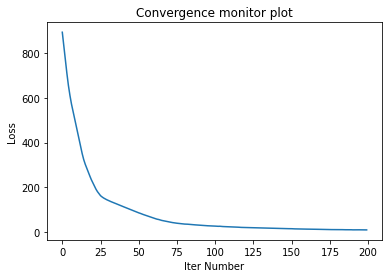

In [16]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [20]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        train_loss += criterion(y_hat, y)*len(X)/train_size
        
        y_train.extend(list(y.detach().cpu().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))


print('Train Loss =', train_loss.item())
pd.DataFrame(confusion_matrix(y_train, y_train_pred))

Train Loss = 9.868721008300781


,0,1,2,3,4,5,6
0,14,5,5,9,3,2,2
1,4,21,1,7,3,2,1
2,12,5,10,16,0,0,2
3,11,3,6,19,2,1,0
4,5,8,7,13,2,2,6
5,7,8,6,12,1,1,2
6,8,5,7,15,0,2,4


In [23]:
acc_tr = accuracy_score(y_train, y_train_pred)
prec_tr = precision_score(y_train, y_train_pred, average='weighted')
f1_tr = f1_score(y_train, y_train_pred, average='weighted')

print('Train Accuracy =', acc_tr, 'Train Precision =', prec_tr, 'Train F1 =', f1_tr)

Train Accuracy = 0.24738675958188153 Train Precision = 0.22550520587104275 Train F1 = 0.21349928256472567


In [21]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        test_loss += criterion(y_hat, y)
        
        y_test.extend(list(y.detach().cpu().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Test Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Test Loss = 21.973230361938477


,0,1,2,3,4,5,6
0,3,2,0,2,0,1,0
1,0,2,0,0,2,0,0
2,1,0,3,2,0,1,0
3,2,1,0,1,0,0,0
4,0,0,2,4,0,0,1
5,0,0,1,3,0,1,0
6,2,0,1,1,1,0,2


In [22]:
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)

Test Accuracy = 0.2857142857142857 Test Precision = 0.3257849293563579 Test F1 = 0.2879518474056289


In [17]:
torch.save(classifier, '/content/drive/My Drive/A3Q3_model.pt')